In [10]:
import dpln
from dpln import nn, optim
from dpln.util import load_pickle
from dpln.data import Dataset, DataLoader

import numpy as np
from matplotlib import pyplot as plt

print(dpln.__version__)

0.1.0


In [11]:
mnist = load_pickle("mnist.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'mnist.pkl'

In [12]:
class MnistDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        if len(images) != len(labels):
            raise ValueError("length of images and labels must equal")
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        r = self.images[idx], self.labels[idx]
        if self.transform is None:
            return r
        else:
            return self.transform(r)


In [13]:
def transform(pair):
    inp = dpln.Tensor(pair[0].reshape(28 * 28) / 256)
    lab = np.zeros(10)
    lab[pair[1]] = 1
    lab = dpln.Tensor(lab)
    return inp, lab


In [14]:
train_ds = MnistDataset(mnist["train_images"], mnist["train_labels"], transform)
test_ds = MnistDataset(mnist["test_images"], mnist["test_labels"], transform)

NameError: name 'mnist' is not defined

In [6]:
def batch_fn(batch):
    images = []
    labels = []
    for i in batch:
        images.append(i[0][np.newaxis, :])
        labels.append(i[1][np.newaxis, :])
    return dpln.concat(images), dpln.concat(labels)


In [7]:
train_ld = DataLoader(train_ds, 50, batch_fn)
test_ld = DataLoader(test_ds, 1000, batch_fn)

In [8]:
sample_image_batch, sample_label_batch = next(iter(train_ld))
sample_image = sample_image_batch.numpy()[0].reshape(1, 784)
sample_label = sample_label_batch.numpy()[0].reshape(1, 10)

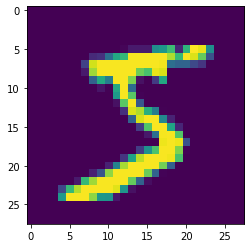

In [9]:
plt.imshow(sample_image.reshape(28, 28))

In [10]:
print(sample_label)

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [11]:
model = nn.Sequential(
    nn.Linear(28 * 28, 64),
    nn.Sigmoid(),
    nn.Linear(64, 32),
    nn.Sigmoid(),
    nn.Linear(32, 10),
    nn.Softmax(),
)

In [2]:
print(model)

NameError: name 'model' is not defined

In [13]:
optm = optim.SGD(model.parameters(), 1)

In [14]:
loss_f = nn.MSELoss()

In [15]:
train_loss = []
train_accu = []

In [16]:
def train_step(epoch: int, model, train_ld, optm, loss_f):
    batch_size = len(train_ld)
    for b, (inp, tar) in enumerate(train_ld):
        optm.zero_grad()
        pre = model(inp)
        loss = loss_f(pre, tar)
        loss.backward()
        optm.step()
        loss_v = loss.numpy()
        train_loss.append(loss_v)
        if b % 100 == 0:
            print(f"Epoch:{epoch + 1}\tStep:{b}/{batch_size}\t\tLoss:{loss_v}")


In [17]:
def accuracy(model, test_ld) -> float:
    correct = 0
    total = 0
    for (inp, tar) in test_ld:
        pre = model(inp)
        pre_am = pre.numpy().argmax(axis=-1)
        tar_am = tar.numpy().argmax(axis=-1)
        res = np.where(pre_am == tar_am, 1, 0)
        correct += res.sum()
        total += res.size
    return correct / total


In [18]:
epochs = 20

In [19]:
for i in range(epochs):
    train_step(i, model, train_ld, optm, loss_f)
    accu = accuracy(model, test_ld)
    train_accu.append(accu)
    print(f"Epoch:{i+1}\tAccu:{accu}")


Epoch:1	Step:0/1200		Loss:0.09024244900814252
Epoch:1	Step:100/1200		Loss:0.08984179173381755
Epoch:1	Step:200/1200		Loss:0.08995014860514579
Epoch:1	Step:300/1200		Loss:0.08991015514721568
Epoch:1	Step:400/1200		Loss:0.08996513943854018
Epoch:1	Step:500/1200		Loss:0.0898448712829739
Epoch:1	Step:600/1200		Loss:0.08998307922285165
Epoch:1	Step:700/1200		Loss:0.08987683266805327
Epoch:1	Step:800/1200		Loss:0.0898898525530576
Epoch:1	Step:900/1200		Loss:0.08998262024264564
Epoch:1	Step:1000/1200		Loss:0.08999302687006337
Epoch:1	Step:1100/1200		Loss:0.08970653843758777
Epoch:1	Accu:0.1028
Epoch:2	Step:0/1200		Loss:0.08981140675783167
Epoch:2	Step:100/1200		Loss:0.08967593732082113
Epoch:2	Step:200/1200		Loss:0.08973364376664429
Epoch:2	Step:300/1200		Loss:0.08969434537678504
Epoch:2	Step:400/1200		Loss:0.08980592358744381
Epoch:2	Step:500/1200		Loss:0.08959812158268332
Epoch:2	Step:600/1200		Loss:0.0897779106724905
Epoch:2	Step:700/1200		Loss:0.08965262712599577
Epoch:2	Step:800/1200		Lo

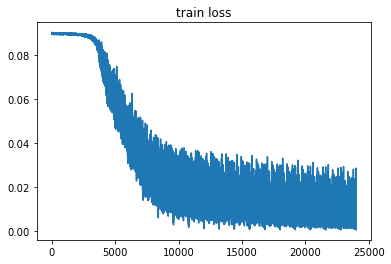

In [20]:
plt.figure()
plt.title("train loss")
plt.plot(train_loss)
plt.show()

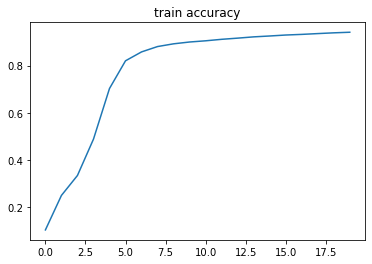

In [21]:
plt.figure()
plt.title("train accuracy")
plt.plot(train_accu)
plt.show()